

We will need the following three python libraries.

In [0]:
!pip install pyspc
!pip install matplotlib
!pip install spm1d


  Created wheel for pyspc: filename=pyspc-0.4-cp36-none-any.whl size=30878 sha256=37fe6b5e0c991e14c5603729f4c259d44db5927aaeae507dec4fbd72bbd532cf
  Stored in directory: /root/.cache/pip/wheels/bf/03/f8/b15370eb2f37f1fbc6b921ce1460d94f81f6cb648926086991
Successfully built pyspc
     |████████████████████████████████| 8.5MB 2.7MB/s 


Now lets load the boston housing data that we used in the univariate approach.

In [0]:
from sklearn.datasets import load_boston
from sklearn.neighbors import DistanceMetric as DM
import numpy as np
import pandas as pd
boston = load_boston()

#print(boston.DESCR)
x = boston.data
y = boston.target
#print(pd.Series(y))
columns = boston.feature_names

#create the dataframe
boston_df = pd.DataFrame(boston.data)
boston_df.columns = columns
#boston_df['Y']=pd.Series(y)
boston_df.head()


CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO       B  LSTAT
0  0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.90   4.98
1  0.02731   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  396.90   9.14
2  0.02729   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  392.83   4.03
3  0.03237   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  394.63   2.94
4  0.06905   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  396.90   5.33

[5 rows x 13 columns]

Now we will use *pyspc* to get a very quick univariate look of a multivariate dataset. In other words we are going to get all the relevant variables and combine them to reduce them to a single variable that will represent all the variables. The piece of code below uses Hotelling T-Square as a guide to tell us the multivariate point is an outlier.  

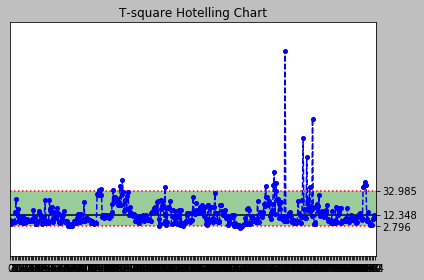

<pyspc: (8731819189824)>


In [0]:
#X = [[0, 1, 2],[3, 4, 5]]
#print(boston_df.columns)
x=boston_df.values.tolist()
#print(boston_df.values.tolist())

from pyspc import *

a = spc(x) + Tsquare_single()

print(a)



You will see from the chart above that we have a number of outliers, points > 32.985. But the problem from a coding perspective is that *pyspc* doesn't give us the distances for each individual row from the overall multivariate average. We need these distances to tell us which points are outliers. This is where the library [*scipy.spatial*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html)  comes in. This library calculates the Mahalanobis distance and then compares this to values for a Hotellings T squared distribution to determine if they are outliers. Its like comparing a single univariate variable to a t-distribution. Have a look at this [link](https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution) to understand this better. The code below is an example for the boston dataset of how to calculate the critical Hotellings T Squared value for the dataset. So any values whose distance is greater than our critical value will be considered outliers.


In [0]:
from scipy.stats import f

x=boston_df.values.tolist()
#print(x))
n=len(x)
k=len(x[0])
vals = f.ppf([0.99], n, k)*(n*k)/((n-k)+1)
print(vals)
rv = f(len(x), len(x[0]))

[42.43560097]


The final piece of code tries to put all this together. We have found our critical values by calculating the Hotellings T-Squared from n rows with k columns. We then calculate the Mahalanobis distance for each row from the overall multivariate mean $\bar{X}$ (xbar). Use this distance with the covariance matrix to calculate individual Hotelling T Squared statistics and  then compare each one to the critical Hotellings T Squared values. You will notice that we have used the covariance matrix to help us standardised the data using *pandas.cov*. There will be small differences between the chart above and the one below as we do not have the exact calculations from *pyspc* but by using the code below we can identify the outlier points.

[42.43560097]
         CRIM   ZN  INDUS  CHAS  ...       B  LSTAT   hotelling  critical value
155   3.53501  0.0  19.58   1.0  ...   88.01  15.02   43.175953       42.435601
365   4.55587  0.0  18.10   0.0  ...  354.70   7.12   50.037564       42.435601
380  88.97620  0.0  18.10   0.0  ...  396.90  17.21  157.559490       42.435601
405  67.92080  0.0  18.10   0.0  ...  384.97  22.98   80.057197       42.435601
410  51.13580  0.0  18.10   0.0  ...    2.60  10.11   63.613343       42.435601
418  73.53410  0.0  18.10   0.0  ...   16.45  20.62   97.508112       42.435601

[6 rows x 15 columns]


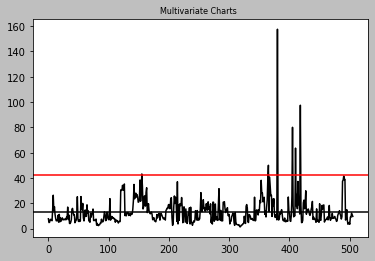

In [0]:
from  scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
#print(boston_df.cov())
inv_cov = pd.DataFrame(np.linalg.pinv(boston_df.cov().values), boston_df.cov().columns, boston_df.cov().index).values.tolist()
x=boston_df.values.tolist()
xbar=boston_df.mean().tolist()

n=len(x)
k=len(x[0])
## Convert f value to hotellings critical value at 1% level
##https://en.wikipedia.org/wiki/Hotelling%27s_T-squared_distribution

Hotvalue = f.ppf([0.99], n, k)*(n*k)/((n-k)+1)
print(Hotvalue)

## calculating hoteling test statistic for each row in boston dataset 

for i in range(0,len(x)):
  
  boston_df.loc[boston_df.index==i,'hotelling']=(n*k)*distance.mahalanobis(x[i], xbar, inv_cov)**2/(k*(n-k))
  boston_df.loc[boston_df.index==i,'critical value']=Hotvalue

x=np.array(boston_df.index.tolist())
y1=np.array(boston_df['hotelling'])
f = plt.figure()

ax = f.add_subplot(111)

plt.plot(x, y1)
plt.axhline(y=boston_df['hotelling'].mean())
plt.axhline(y=Hotvalue,color='r')
#plt.axhline(y=boston_df['hotelling'].mean()+3*boston_df['hotelling'].std(),color='r')
#plt.axhline(y=boston_df['hotelling'].mean()-3*boston_df['hotelling'].std(),color='r')

plt.title('Multivariate Charts  ', fontsize=8)
print(boston_df.loc[boston_df['hotelling']>boston_df['critical value']])

You should be able to use this in-depth based approach to help you identify multivariate outliers. It is worth looking at this [article](https://onlinelibrary.wiley.com/doi/full/10.1002/cem.2763) from Richard Brereton if you want more detail. The code I have developed above is based on this paper.</br></br>
Finally, play with the data and test out for yourself if you can find or identify new outliers that you may create. Share your conclusions amongst the class. 


Let us know in the comments section on Futurelearn [here]( https://www.futurelearn.com/courses/pre-processing-data-and-feature-impact-calculation/1/steps/687909).
